In [224]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from IPython.display import display
# from typen import enforce_type_hints

%load_ext autoreload
%autoreload 2

from scripts import *

In [ ]:
%store -r df_merged
df_merged

In [273]:
class Slicer():
    def __getitem__(self, slice_):
        return slice_

class Prediction:
    cat_cols = None
    test_period = None
    df_merged_w_preds = None
    
    def __init__(self, df,  min_t=-1, train_period=Slicer()['2012':'2019-03'], test_period=Slicer()['2019-11':], drop_cols=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'], target='diff', cat_cols=['DD','DD_', 'Cl', 'Cm','Ch', 'H', 'RRR']):
        
        self.cat_cols = cat_cols
        self.test_period = test_period
        
        self.df_merged_c = df.copy()  # load data
        self.df_merged_c = self.df_merged_c[self.df_merged_c['abs_diff'] > min_t]
        
        self.df_merged_c['Cl'] = self.df_merged_c['Cl'].fillna(0)
        self.df_merged_c['Ch'] = self.df_merged_c['Ch'].fillna(0)
        self.df_merged_c['Cm'] = self.df_merged_c['Cm'].fillna(0)
        self.df_merged_c['H'] = self.df_merged_c['H'].fillna(0)
        self.df_merged_c['RRR'] = self.df_merged_c['RRR'].fillna(0)
        
        self.train_data = self.df_merged_c[train_period]
        self.train_data = self.train_data.drop(columns=drop_cols)
        self.eval_data = self.df_merged_c[test_period]
        self.eval_data = self.eval_data.drop(columns=drop_cols)
        self.train_labels = self.df_merged_c[train_period][target]
        
    def fit(self):
        self.model = CatBoostRegressor(iterations=1000, # {'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}
                           task_type="GPU",
                           devices='0:1',
                         depth=10,
                         l2_leaf_reg=5,
                         learning_rate=0.3)
        
#         display(self.train_data.info())
        
        self.model.fit(self.train_data,
          self.train_labels,
          verbose=False,
         cat_features=self.cat_cols)
        
    def plot_feature_imp(self):
        plt.bar(self.train_data.columns, self.model.get_feature_importance())
        plt.show()
        
    def mape_vectorized_v2(self, x):
        a = x['diff']
        b = x['diff_p']
        mask = a != 0
        return (np.fabs((a - b))/a)[mask].mean()

    def mean_absolute_percentage_error(self, x):
        y_true = x['diff']
        y_pred = x['diff_p']
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    def predict(self):
        preds = self.model.predict(self.eval_data)
        
        mape_vectorized_v2 = self.mape_vectorized_v2
        mean_absolute_percentage_error = self.mean_absolute_percentage_error
        
        eps = 1e-6
        df_merged_w_preds = self.df_merged_c[self.test_period].copy()
        df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
        df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
        df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)
        df_merged_w_preds['error rel lg'] = np.log(abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)*10 +1)
        df_merged_w_preds['mape'] = df_merged_w_preds.apply(mean_absolute_percentage_error, axis=1)
        
        self.df_merged_w_preds = df_merged_w_preds
        
        display(df_merged_w_preds[['diff', 'diff_p', 'error', 'error rel', 'error rel lg']])
    def mean_error(self, t_diff=1):
        display(self.df_merged_w_preds['error'][self.df_merged_w_preds['abs_diff'] > t_diff].mean())
    def mean_diff(self, t_diff=1):
        display(abs(self.df_merged_w_preds['diff'][self.df_merged_w_preds['abs_diff'] > t_diff]).mean())

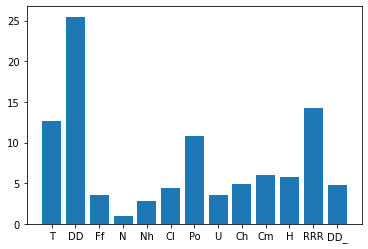

In [401]:
# predict temp. diff:
pred = Prediction(df_merged, 0)
pred.fit()
pred.plot_feature_imp()

In [402]:
pred.predict()

,diff,diff_p,error,error rel,error rel lg
index,,,,,
2019-11-01 00:00:00,0.1,-0.140992,0.240992,2.409917,3.222835
2019-11-01 03:00:00,-0.4,-0.349605,0.050395,0.125986,0.815301
2019-11-01 06:00:00,0.2,-0.112507,0.312507,1.562537,2.810930
2019-11-01 09:00:00,1.2,-0.068031,1.268031,1.056694,2.448151
2019-11-01 12:00:00,-0.2,-0.208905,0.008905,0.044522,0.368262
...,...,...,...,...,...
2021-02-28 09:00:00,-1.8,-0.666044,1.133956,0.629974,1.987839
2021-02-28 12:00:00,-0.7,-1.618001,0.918001,1.311428,2.647187
2021-02-28 15:00:00,-0.2,-1.313020,1.113020,5.565097,4.036909


In [406]:
pred.mean_error(1)
pred.mean_diff(1)

1.095090797919869

1.8663883089770361

In [133]:
#
class WeatherData:
    conn = None
    weather = None
#     @enforce_type_hints
    def __init__(self, db_name: str) -> pd.core.frame.DataFrame:
        self.conn = sql.connect(db_name)
    def select_all(self, table_name: str):
        self.weather = pd.read_sql(f'SELECT * FROM {table_name}', self.conn)
        self.weather['index'] = pd.to_datetime(self.weather['index'], dayfirst=True)
        self.weather.index = self.weather['index']
        self.weather = self.weather.drop(columns=['index'])
        return self.weather
    def mean_by(self, month: bool = True, year: bool = False) -> pd.core.frame.DataFrame:
        if self.weather is None:
            raise Exception('You must call select_all for set table name first')
        if month == True:
            return self.weather.groupby(by=self.weather.index.month).mean().head()['T']
        if year == True:
            return self.weather.groupby(by=self.weather.index.year).mean().head()['T']
    @staticmethod
    def bar_chart(data: pd.core.frame.DataFrame) -> None:
        display(data.plot(kind='bar'))
        
    @staticmethod    
    def print_head(table: pd.core.frame.DataFrame, count: int = 5) -> None:
        display(table.head(count))

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
index,,,,,,,,,,,,,,,,,,,,,
2012-11-01 00:00:00,-1.9,-6.0,"Ветер, дующий с северо-запада",3.0,0.0,NaN,None,763.7,75.0,None,...,None,North,4.1,4.1,-4.8,-4.0,-4.0,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,"Ветер, дующий с северо-запада",2.0,10.0,10.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...",...,None,North,3.3,3.3,-5.4,-5.8,-4.7,-5.300000,1.600000,1.600000


Средняя температура по месяцам:


<AxesSubplot:xlabel='index'>

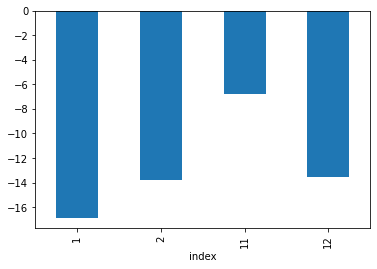

In [134]:
wd = WeatherData('weather.db')
wd.print_head(wd.select_all('df_merged'), 2)
print('Средняя температура по месяцам:')
wd.mean_by()
wd.bar_chart(wd.mean_by())

In [310]:
df_merged.loc['2015-01-05']

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
index,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00,-5.7,-6.0,"Ветер, дующий с юга",4.0,100.0,100.0,"Слоисто-кучевые, образовавшиеся не из кучевых.",745.3,72.0,None,...,None,South,0.3,0.3,-6.0,-7.3,-13.8,-9.033333,3.333333,3.333333
2015-01-05 03:00:00,-6.5,-6.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевые, образовавшиеся не из кучевых.",745.1,76.0,None,...,None,South,-0.5,0.5,-6.8,-6.5,-5.0,-6.100000,-0.400000,0.400000
2015-01-05 06:00:00,-5.4,-5.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.6,90.0,None,...,None,South,-0.4,0.4,-5.4,-5.7,-5.5,-5.533333,0.133333,0.133333
2015-01-05 09:00:00,-5.0,-5.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.2,88.0,None,...,1.0,South,0.0,0.0,-5.6,-4.6,-4.4,-4.866667,-0.133333,0.133333
2015-01-05 12:00:00,-4.2,-4.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.0,89.0,None,...,None,South,-0.2,0.2,-4.5,-3.2,-3.3,-3.666667,-0.533333,0.533333
2015-01-05 15:00:00,-2.7,-2.0,"Ветер, дующий с юго-запада",2.0,100.0,40.0,Кучево-дождевые волокнистые (часто с наковальн...,744.0,86.0,None,...,None,West,-0.7,0.7,-3.4,-1.3,-2.4,-2.366667,-0.333333,0.333333
2015-01-05 18:00:00,-2.3,-2.0,"Ветер, дующий с юго-юго-запада",2.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.9,92.0,None,...,None,South,-0.3,0.3,-2.7,-1.2,-1.4,-1.766667,-0.533333,0.533333
2015-01-05 21:00:00,-1.3,-2.0,"Ветер, дующий с юго-запада",2.0,100.0,100.0,Слоистые туманообразные или слоистые разорванн...,745.5,92.0,None,...,0.2,West,0.7,0.7,-2.0,-1.3,-1.0,-1.433333,0.133333,0.133333


#### агрегация (омск - аэропорт)

In [494]:
class AggData:
    def __init__(self, df_merged, w_calm=False):
        self.df_merged = df_merged
        if (w_calm == False):
            self.df_merged = df_merged[df_merged['DD_'] != 'Calm']
    def all_data(self, min_diff=0, only_temp_below=30, with_plot=False, with_kde=False, kde_abs_diff=False, Nh=-1, Po=-1):
        df_merged = self.df_merged
        
        if only_temp_below != 30:
            df_merged = df_merged[df_merged['T'] <= only_temp_below]
        if Nh != -1:
            df_merged = df_merged[df_merged['Nh'] >= Nh]
        if Po != -1:
            df_merged = df_merged[df_merged['Po'] <= Po]
        
        if (min_diff != 0):
            data = df_merged[df_merged['abs_diff'] >= min_diff].groupby('DD_', as_index=False)[['diff', 'abs_diff']].mean()
            data_ = df_merged[df_merged['abs_diff'] >= min_diff]
        else:
            data = df_merged.groupby('DD_', as_index=False)[['diff', 'abs_diff']].mean()
            data_ = df_merged
        self.show(data)
        if (with_plot):
            self.show_pie(data_)
        if (with_kde):
            if kde_abs_diff:
                self.show_kde(data_, abs_diff=True)
            else:
                self.show_kde(data_, abs_diff=False)
                
        print('rows: ', len(df_merged.index))
            
    def show(self, data):
        display(data)
    def show_pie(self, data):
        display(data['DD_'].value_counts().plot(kind='pie'))
    def show_kde(self, data, abs_diff=False):
        if abs_diff:
            fig, ax = plt.subplots()
            data[(data['DD_'] == 'East')]['abs_diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'North')]['abs_diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'South')]['abs_diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'West')]['abs_diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            ax.legend(["East", "North", "South", "West"])
        else:
            fig, ax = plt.subplots()
            data[(data['DD_'] == 'East')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'North')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'South')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'West')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
            ax.legend(["East", "North", "South", "West"])

,DD_,diff,abs_diff
0,East,-0.050000,0.150000
1,North,-1.180000,1.180000
2,South,1.053846,1.392308
3,West,0.714286,0.780952


<AxesSubplot:ylabel='DD_'>

rows:  41


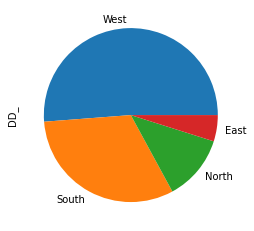

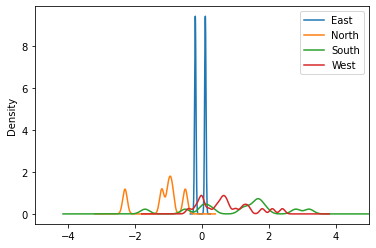

In [501]:
weatherC = AggData(df_merged, w_calm=False)
weatherC.all_data(min_diff=0, with_plot=True, with_kde = True, only_temp_below=-22, Nh=-1, Po=750)

,DD_,diff,abs_diff
0,East,-1.292893,1.706858
1,North,-1.045680,1.848272
2,South,1.485849,1.798008
3,West,1.664634,1.843902


<AxesSubplot:ylabel='DD_'>

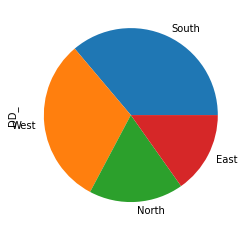

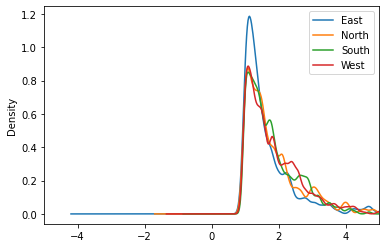

In [384]:
weatherC.all_data(min_diff=1, with_plot=True, with_kde = True, kde_abs_diff=True)